In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df  = pd.read_csv('./data.csv')
df.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49438 entries, 0 to 49437
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45987 non-null  object 
 3   category_list         45475 non-null  object 
 4    market               45468 non-null  object 
 5    funding_total_usd    49434 non-null  object 
 6   status                48120 non-null  object 
 7   country_code          44162 non-null  object 
 8   state_code            30159 non-null  object 
 9   region                44162 non-null  object 
 10  city                  43319 non-null  object 
 11  funding_rounds        49434 non-null  float64
 12  founded_at            38551 non-null  object 
 13  founded_month         38479 non-null  object 
 14  founded_quarter       38479 non-null  object 
 15  founded_year       

In [4]:
df_copy = df.copy()

In [3]:
df.rename(columns={' funding_total_usd ': "funding_total_usd",
                    ' market ': "market"},inplace=True)

In [6]:
df['funding_total_usd_clean'] = df['funding_total_usd'].str.replace(',', '')
df['funding_total_usd_clean'] = df['funding_total_usd_clean'].str.replace('-', '0')
df['funding_total_usd_clean'] = pd.to_numeric(df['funding_total_usd_clean'], errors='coerce')

### Missing data

In [6]:
column = list(df.columns)
stat = {}
for col in column:
    stat[col] =  [df[col].nunique(), df[col].isna().sum(), df[col].dtype]
term =  pd.DataFrame.from_dict(stat, orient='index', columns=['Unique',  'Missed values in %', 'DType'])
term = term.sort_values(by='Missed values in %',ascending= False)

In [7]:
df.isnull().sum().sum()

92517

In [8]:
df = df.drop_duplicates()
df.shape

(49438, 39)

In [9]:
for col in df.columns:
    if term.loc[col]['Missed values in %'] <= 4:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)

column = list(df.columns)
stat = {}
for col in column:
    stat[col] =  [df[col].nunique(), df[col].isna().sum(), df[col].dtype]
term1 =  pd.DataFrame.from_dict(stat, orient='index', columns=['Unique',  'Missed values in %', 'DType'])
term1 = term1.sort_values(by='Missed values in %',ascending= False)
term1

C:\Users\COMPUTER\AppData\Local\Temp\ipykernel_19656\642785772.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


,Unique,Missed values in %,DType
state_code,61,19279,object
founded_year,103,10959,float64
founded_quarter,218,10959,object
founded_month,420,10959,object
founded_at,3369,10887,object
city,4187,6119,object
country_code,115,5276,object
region,1089,5276,object
market,753,3970,object
category_list,16674,3963,object


In [10]:
df = df.drop(['permalink','homepage_url' ,'state_code','region','city','category_list', 'name'], axis=1)

In [11]:
df = df.dropna()
df.shape

(33151, 32)

In [12]:
df.isnull().sum().sum()

0

In [13]:
column = list(df.columns)
stat = {}
for col in column:
    stat[col] =  [df[col].nunique(), df[col].isna().sum(), df[col].dtype]
term1 =  pd.DataFrame.from_dict(stat, orient='index', columns=['Unique',  'Missed values in %', 'DType'])
term1 = term1.sort_values(by='Missed values in %',ascending= False)
term1

,Unique,Missed values in %,DType
market,720,0,object
funding_total_usd,10831,0,object
round_G,30,0,float64
round_F,101,0,float64
round_E,206,0,float64
round_D,398,0,float64
round_C,618,0,float64
round_B,1031,0,float64
round_A,1505,0,float64
product_crowdfunding,126,0,float64


Data Transformation

covert các cột datetime

In [14]:
df[['founded_at','first_funding_at','last_funding_at']].head()

,founded_at,first_funding_at,last_funding_at
0,01/06/2012,30/06/2012,30/06/2012
2,26/10/2012,09/08/2012,09/08/2012
3,01/04/2011,01/04/2011,01/04/2011
4,01/01/2014,17/08/2014,26/09/2014
8,01/01/2010,24/07/2014,24/07/2014


In [15]:
format_date = ('founded_at','first_funding_at','last_funding_at')
for i in format_date:
  df[i] = pd.to_datetime(df[i], errors = 'coerce')

C:\Users\COMPUTER\AppData\Local\Temp\ipykernel_19656\425228424.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[i] = pd.to_datetime(df[i], errors = 'coerce')
C:\Users\COMPUTER\AppData\Local\Temp\ipykernel_19656\425228424.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[i] = pd.to_datetime(df[i], errors = 'coerce')


In [16]:
#Để giảm độ phức tạp, trong khi xử lý các trường biến ngày, chuyển đổi ngày thực tế thành ngày tương đối, mô tả khoảng cách từ khi thành lập đến lần cấp vốn đầu tiên và cuối cùng, sau đó bỏ ngày thành lập.

df['age_first_funding'] = (df['first_funding_at']-df['founded_at'])/pd.Timedelta(days=365)
df['age_last_funding'] = (df['last_funding_at']-df['founded_at'])/pd.Timedelta(days=365)
df['founded_month'] = pd.DatetimeIndex(df['founded_at']).month
df['founded_quarter'] = pd.DatetimeIndex(df['founded_at']).quarter

In [17]:
df = df.drop(['first_funding_at','last_funding_at','founded_at'],axis=1)

In [18]:
df.head()

,market,funding_total_usd,status,country_code,funding_rounds,founded_month,founded_quarter,founded_year,seed,venture,...,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,age_last_funding
0,News,"17,50,000",acquired,USA,1.0,1.0,1.0,2012.0,1750000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.482192,0.482192
2,Publishing,"40,000",operating,EST,1.0,NaN,NaN,2012.0,40000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,Electronics,"15,00,000",operating,GBR,1.0,1.0,1.0,2011.0,1500000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238356,0.238356
4,Tourism,"60,000",operating,USA,2.0,1.0,1.0,2014.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624658,0.734247
8,Software,-,operating,USA,1.0,1.0,1.0,2010.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.561644,4.561644


Xem giá trị khác nhau của từng cột

In [19]:

num_unique_country_code = df['country_code'].nunique()
num_unique_market = df['market'].nunique()
num_unique_status = df['status'].nunique()

print("Số lượng giá trị khác nhau trong cột 'market':", num_unique_market)
print("Số lượng giá trị khác nhau trong cột 'country_code':", num_unique_country_code)
print("Số lượng giá trị khác nhau trong cột 'status':", num_unique_status)

Số lượng giá trị khác nhau trong cột 'market': 720
Số lượng giá trị khác nhau trong cột 'country_code': 109
Số lượng giá trị khác nhau trong cột 'status': 3


Hiển thị phân phối của các giá trị

In [20]:
market_distribution = df['market'].value_counts().reset_index()
market_distribution.columns = ['market', 'count']
print("\nPhân phối của các giá trị trong cột 'market':\n", market_distribution)


Phân phối của các giá trị trong cột 'market':
                     market  count
0                Software    3525
1           Biotechnology    2361
2                  Mobile    1425
3              E-Commerce    1262
4             Curated Web    1163
..                     ...    ...
715        Weird Hardware       1
716         App Discovery       1
717      Low Bid Auctions       1
718              Realtors       1
719   Clean Technology IT       1

[720 rows x 2 columns]


Gom nhóm các giá trị ít xuất hiện

In [21]:
# Chọn ngưỡng
threshold = 200

# Lấy các giá trị hiếm xuất hiện
rare_values = df['market'].value_counts()[df['market'].value_counts() < threshold].index

# Gom nhóm các giá trị hiếm xuất hiện lại thành 'Others'
df.loc[df['market'].isin(rare_values), 'market'] = 'Others'


In [22]:
df.head()

,market,funding_total_usd,status,country_code,funding_rounds,founded_month,founded_quarter,founded_year,seed,venture,...,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,age_last_funding
0,News,"17,50,000",acquired,USA,1.0,1.0,1.0,2012.0,1750000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.482192,0.482192
2,Others,"40,000",operating,EST,1.0,NaN,NaN,2012.0,40000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,Others,"15,00,000",operating,GBR,1.0,1.0,1.0,2011.0,1500000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238356,0.238356
4,Others,"60,000",operating,USA,2.0,1.0,1.0,2014.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624658,0.734247
8,Software,-,operating,USA,1.0,1.0,1.0,2010.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.561644,4.561644


Xét cột country_code

In [23]:
country_code_distribution = df['country_code'].value_counts().reset_index()
country_code_distribution.columns = ['country_code', 'count']
print("\nPhân phối của các giá trị trong cột 'country_code':\n", country_code_distribution)


Phân phối của các giá trị trong cột 'country_code':
     country_code  count
0            USA  22219
1            GBR   1901
2            CAN   1040
3            DEU    702
4            IND    646
..           ...    ...
104          SOM      1
105          NIC      1
106          SYC      1
107          MAF      1
108          LAO      1

[109 rows x 2 columns]


Chọn ngưỡng

In [24]:
# Chọn ngưỡng
threshold = 100
# Lấy các giá trị hiếm xuất hiện
rare_values = df['country_code'].value_counts()[df['country_code'].value_counts() < threshold].index
# Gom nhóm các giá trị hiếm xuất hiện lại thành 'Others'
df.loc[df['country_code'].isin(rare_values), 'country_code'] = 'Remaining'

### Categorical Data Encoding


#### Label Encoding

In [25]:
df.head(5)

,market,funding_total_usd,status,country_code,funding_rounds,founded_month,founded_quarter,founded_year,seed,venture,...,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,age_last_funding
0,News,"17,50,000",acquired,USA,1.0,1.0,1.0,2012.0,1750000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.482192,0.482192
2,Others,"40,000",operating,Remaining,1.0,NaN,NaN,2012.0,40000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,Others,"15,00,000",operating,GBR,1.0,1.0,1.0,2011.0,1500000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238356,0.238356
4,Others,"60,000",operating,USA,2.0,1.0,1.0,2014.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624658,0.734247
8,Software,-,operating,USA,1.0,1.0,1.0,2010.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.561644,4.561644


Lựa chọn các cột 'status' và 'country_code' từ DataFrame để mã hóa

In [26]:
df1 = df[["status","country_code"]]
df1.head(10)


,status,country_code
0,acquired,USA
2,operating,Remaining
3,operating,GBR
4,operating,USA
8,operating,USA
10,operating,CHL
12,operating,USA
13,operating,USA
14,operating,USA
15,operating,GBR


#### Vẽ biểu đồ trước khi mã hóa của cột "status"

Text(0.5, 1.0, 'Original Status Distribution')

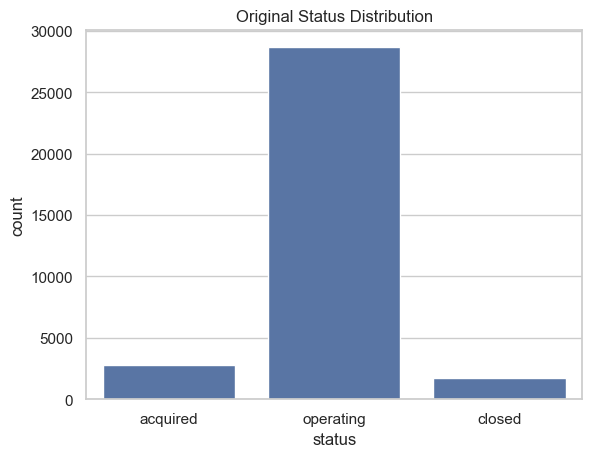

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
sns.set(style="whitegrid")

# Plotting the original 'status' column
sns.countplot(x='status', data=df)
plt.title('Original Status Distribution')


#### Status

In ra các giá trị duy nhất trong cột 'status' để kiểm tra

In [28]:
print(df['status'].unique())


['acquired' 'operating' 'closed']


Áp dụng Label Encoding cho cột 'status' 


In [29]:
from sklearn.preprocessing import LabelEncoder

data_temp = df.copy()
data_temp['status'] = data_temp['status'].replace(['acquired', 'closed'], 'non-operating')

le_temp = LabelEncoder()
le_temp.fit(data_temp['status'])

df['le_status'] = le_temp.transform(data_temp['status'])

df.head()


,market,funding_total_usd,status,country_code,funding_rounds,founded_month,founded_quarter,founded_year,seed,venture,...,round_B,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,age_last_funding,le_status
0,News,"17,50,000",acquired,USA,1.0,1.0,1.0,2012.0,1750000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.482192,0.482192,0
2,Others,"40,000",operating,Remaining,1.0,NaN,NaN,2012.0,40000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1
3,Others,"15,00,000",operating,GBR,1.0,1.0,1.0,2011.0,1500000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238356,0.238356,1
4,Others,"60,000",operating,USA,2.0,1.0,1.0,2014.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624658,0.734247,1
8,Software,-,operating,USA,1.0,1.0,1.0,2010.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.561644,4.561644,1


#### Vẽ biểu đồ sau khi mã hóa của cột "status"

Text(0.5, 1.0, 'Encoded Status Distribution')

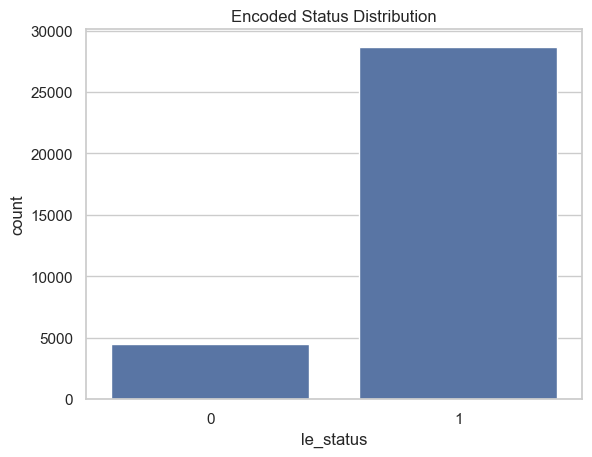

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
sns.set(style="whitegrid")

# Plotting the original 'status' column
sns.countplot(x='le_status', data=df)
plt.title('Encoded Status Distribution')


### Handling Imbalanced Datasets

#### Upsampling

In [31]:
df["le_status"].value_counts()

le_status
1    28670
0     4481
Name: count, dtype: int64

In [34]:
le_status_1 = df[df["le_status"] == 1]
le_status_0 = df[df["le_status"] == 0]

In [43]:
from sklearn.utils import resample
le_status_0_upsampled  = resample(le_status_0,
             replace=True, 
             n_samples=len(le_status_1), 
             random_state=27)


In [44]:
le_status_up = pd.concat([le_status_1, le_status_0_upsampled ])


<Axes: xlabel='le_status', ylabel='count'>

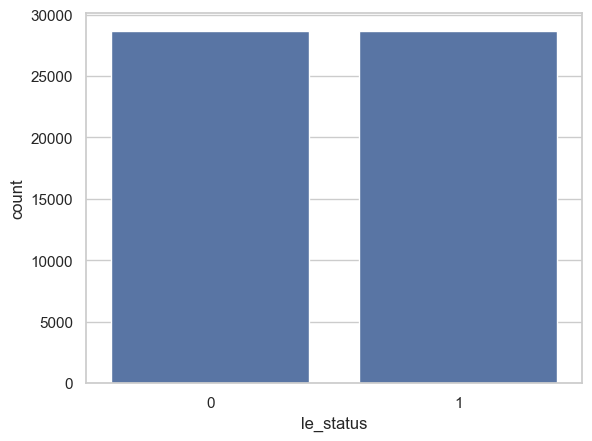

In [45]:
sns.countplot(x='le_status', data=le_status_up)

In [47]:
le_status_up["le_status"].value_counts()

le_status
1    28670
0    28670
Name: count, dtype: int64

#### Vẽ biểu đồ trước khi mã hóa của cột "country_code"

#### Country_code

Huấn luyện (fit) LabelEncoder với dữ liệu từ cột 'country_code'


Text(0.5, 1.0, 'Original Country_code Distribution')

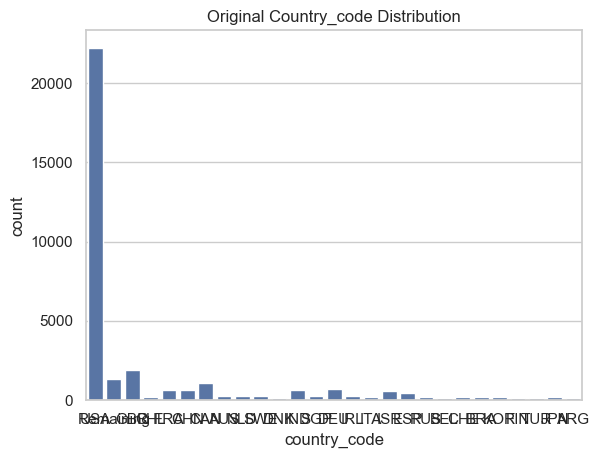

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
sns.set(style="whitegrid")

# Plotting the original 'status' column
sns.countplot(x='country_code', data=df)
plt.title('Original Country_code Distribution')


In [49]:
le = LabelEncoder()
le.fit(df['country_code'])


LabelEncoder()

Áp dụng Label Encoding lên cột 'country_code' và tạo một cột mới lưu kết quả

In [50]:
df['le_country_code'] = le.transform(df['country_code'])
df.head()

,market,funding_total_usd,status,country_code,funding_rounds,founded_month,founded_quarter,founded_year,seed,venture,...,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,age_last_funding,le_status,le_country_code
0,News,"17,50,000",acquired,USA,1.0,1.0,1.0,2012.0,1750000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.482192,0.482192,0,26
2,Others,"40,000",operating,Remaining,1.0,NaN,NaN,2012.0,40000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1,22
3,Others,"15,00,000",operating,GBR,1.0,1.0,1.0,2011.0,1500000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.238356,0.238356,1,13
4,Others,"60,000",operating,USA,2.0,1.0,1.0,2014.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.624658,0.734247,1,26
8,Software,-,operating,USA,1.0,1.0,1.0,2010.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.561644,4.561644,1,26


#### Vẽ biểu đồ sau khi mã hóa của cột "country_code"

Text(0.5, 1.0, 'Encoded Country_code Distribution')

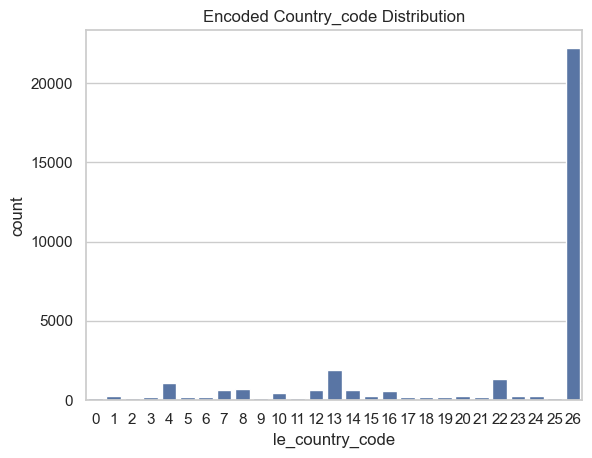

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
sns.set(style="whitegrid")

# Plotting the original 'status' column
sns.countplot(x='le_country_code', data=df)
plt.title('Encoded Country_code Distribution')


In ra các lớp đã được LabelEncoder để kiểm tra

In [52]:
le.classes_

array(['ARG', 'AUS', 'BEL', 'BRA', 'CAN', 'CHE', 'CHL', 'CHN', 'DEU',
       'DNK', 'ESP', 'FIN', 'FRA', 'GBR', 'IND', 'IRL', 'ISR', 'ITA',
       'JPN', 'KOR', 'NLD', 'RUS', 'Remaining', 'SGP', 'SWE', 'TUR',
       'USA'], dtype=object)

In [53]:
df.head()

,market,funding_total_usd,status,country_code,funding_rounds,founded_month,founded_quarter,founded_year,seed,venture,...,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,age_last_funding,le_status,le_country_code
0,News,"17,50,000",acquired,USA,1.0,1.0,1.0,2012.0,1750000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.482192,0.482192,0,26
2,Others,"40,000",operating,Remaining,1.0,NaN,NaN,2012.0,40000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1,22
3,Others,"15,00,000",operating,GBR,1.0,1.0,1.0,2011.0,1500000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.238356,0.238356,1,13
4,Others,"60,000",operating,USA,2.0,1.0,1.0,2014.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.624658,0.734247,1,26
8,Software,-,operating,USA,1.0,1.0,1.0,2010.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.561644,4.561644,1,26


### Xử lý Outlier cho Funding_total_usd

In [7]:
column_to_check = 'funding_total_usd_clean'

In [8]:
Q1 = df['funding_total_usd_clean'].quantile(0.25)
Q3 = df['funding_total_usd_clean'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [9]:
threshold = 1.5

In [10]:
outliers = df[(df[column_to_check] < (Q1 - threshold * IQR)) | (df[column_to_check] > (Q3 + threshold * IQR))]


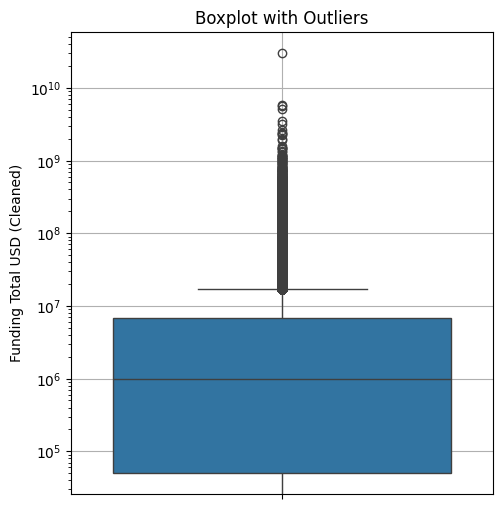

In [11]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['funding_total_usd_clean'])
plt.title('Boxplot with Outliers')
plt.ylabel('Funding Total USD (Cleaned)')
plt.yscale('log')
plt.grid(True)

In [12]:
data_no_outliers = df[(df['funding_total_usd_clean'] >= lower_bound) &
                        (df['funding_total_usd_clean'] <= upper_bound)]



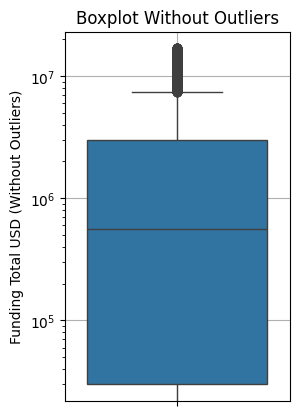

In [13]:
plt.subplot(1, 2, 2)
sns.boxplot(y=data_no_outliers['funding_total_usd_clean'])
plt.title('Boxplot Without Outliers')
plt.ylabel('Funding Total USD (Without Outliers)')
plt.yscale('log')
plt.grid(True)

### Xử lý Outlier Funding_rounds

In [14]:
column_to_check_round = 'funding_rounds'

In [15]:
Q1_round = df['funding_rounds'].quantile(0.25)
Q3_round = df['funding_rounds'].quantile(0.75)
IQR_round = Q3_round - Q1_round
lower_bound_round = Q1_round - 1.5 * IQR_round
upper_bound_round = Q3_round + 1.5 * IQR_round

In [16]:
outliers_round = df[(df[column_to_check_round] < (Q1_round - threshold * IQR_round)) | (df[column_to_check_round] > (Q3_round + threshold * IQR_round))]


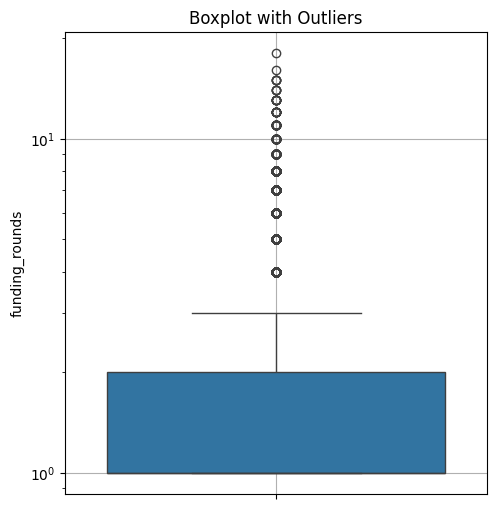

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['funding_rounds'])
plt.title('Boxplot with Outliers')
plt.ylabel('funding_rounds')
plt.yscale('log')
plt.grid(True)

In [18]:
data_no_outliers_round = df[(df['funding_rounds'] >= lower_bound_round) &
                        (df['funding_rounds'] <= upper_bound_round)]

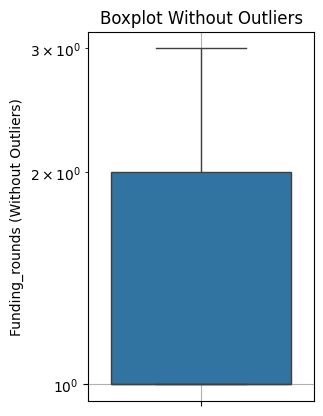

In [19]:
plt.subplot(1, 2, 2)
sns.boxplot(y=data_no_outliers_round['funding_rounds'])
plt.title('Boxplot Without Outliers')
plt.ylabel('Funding_rounds (Without Outliers)')
plt.yscale('log')
plt.grid(True)

### Xử lý Outlier cho Founded_year

In [20]:
column_to_check = 'founded_year'

In [21]:
Q1 = df['founded_year'].quantile(0.25)
Q3 = df['founded_year'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [22]:
outliers = df[(df[column_to_check] < (Q1 - threshold * IQR)) | (df[column_to_check] > (Q3 + threshold * IQR))]

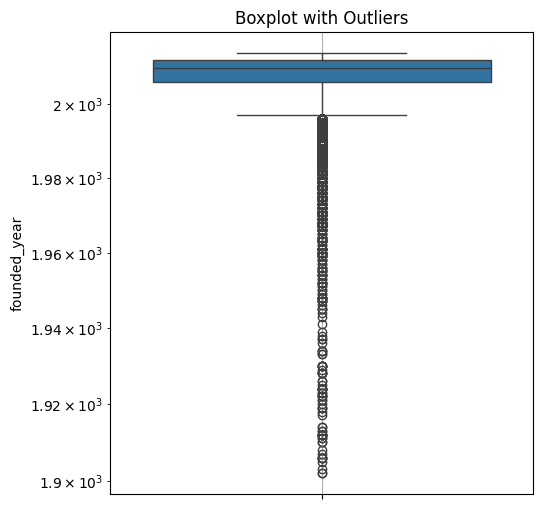

In [23]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['founded_year'])
plt.title('Boxplot with Outliers')
plt.ylabel('founded_year')
plt.yscale('log')
plt.grid(True)

In [24]:
data_no_outliers = df[(df['founded_year'] >= lower_bound) &
                        (df['founded_year'] <= upper_bound)]

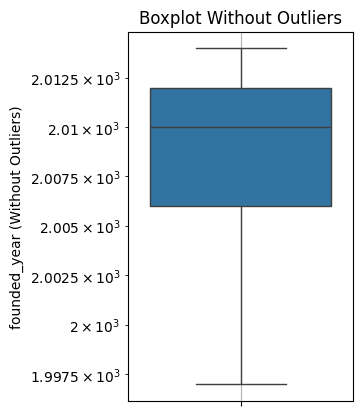

In [25]:
plt.subplot(1, 2, 2)
sns.boxplot(y=data_no_outliers['founded_year'])
plt.title('Boxplot Without Outliers')
plt.ylabel('founded_year (Without Outliers)')
plt.yscale('log')
plt.grid(True)

### Xử lý Outlier cho Venture

In [26]:
column_to_check_venture = 'venture'

In [27]:
Q1_venture = df['venture'].quantile(0.25)
Q3_venture = df['venture'].quantile(0.75)
IQR_venture = Q3_venture - Q1_venture
lower_bound_venture = Q1_venture - 1.5 * IQR_venture
upper_bound_venture = Q3_venture + 1.5 * IQR_venture

In [28]:
outliers_venture = df[(df[column_to_check_venture] < (Q1_venture - threshold * IQR_venture)) | (df[column_to_check_venture] > (Q3_venture + threshold * IQR_venture))]

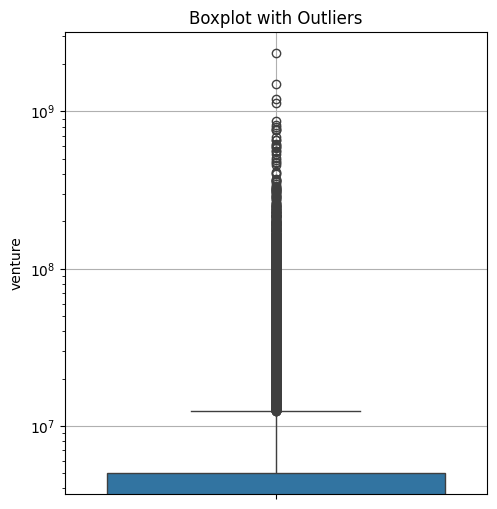

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['venture'])
plt.title('Boxplot with Outliers')
plt.ylabel('venture')
plt.yscale('log')
plt.grid(True)

In [30]:
data_trimmed_venture = df[(df['venture'] >= lower_bound_venture) & (df['venture'] <= upper_bound_venture)]

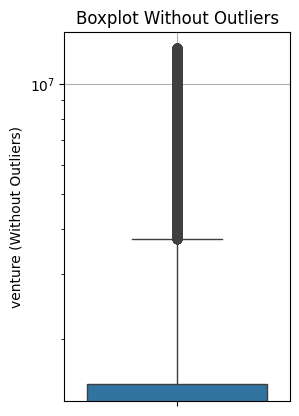

In [31]:
plt.subplot(1, 2, 2)
sns.boxplot(y=data_trimmed_venture['venture'])
plt.title('Boxplot Without Outliers')
plt.ylabel('venture (Without Outliers)')
plt.yscale('log')
plt.grid(True)

### Chuẩn hóa Min-Max Scaler , StandardScaler

In [32]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [33]:
min_max_scaler = MinMaxScaler()

In [34]:
standard_scaler = StandardScaler()

In [35]:
df['funding_total_usd_standard'] = standard_scaler.fit_transform(df[['funding_total_usd_clean']])

In [36]:
df['funding_total_usd_min_max'] = min_max_scaler.fit_transform(df[['funding_total_usd_clean']])

In [39]:
print(df[['funding_total_usd_clean', 'funding_total_usd_min_max']].head())

   funding_total_usd_clean  funding_total_usd_min_max
0                1750000.0                   0.000058
1                4000000.0                   0.000133
2                  40000.0                   0.000001
3                1500000.0                   0.000050
4                  60000.0                   0.000002


In [40]:
df_copy = df.copy()

In [41]:
df_copy['market'] = df_copy['market'].str.strip()

df_copy['homepage_url'] = df_copy['homepage_url'].apply(lambda x: x if pd.isnull(x) or x.startswith(('http://', 'https://')) else 'http://' + x)

df_copy['country_code'] = df_copy['country_code'].str.upper()
df_copy['state_code'] = df_copy['state_code'].str.upper()

In [42]:
# Kết hợp dữ liệu trước và sau để so sánh trực tiếp
comparison_data = pd.concat([df.rename(lambda x: x + ' (Before)', axis='columns'), 
                             df_copy.rename(lambda x: x + ' (After)', axis='columns')], axis=1)

comparison_data


,permalink (Before),name (Before),homepage_url (Before),category_list (Before),market (Before),funding_total_usd (Before),status (Before),country_code (Before),state_code (Before),region (Before),...,round_B (After),round_C (After),round_D (After),round_E (After),round_F (After),round_G (After),round_H (After),funding_total_usd_clean (After),funding_total_usd_standard (After),funding_total_usd_min_max (After)
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1750000.0,-0.074352,0.000058
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000000.0,-0.059700,0.000133
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40000.0,-0.085488,0.000001
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500000.0,-0.075980,0.000050
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60000.0,-0.085358,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49433,/organization/zzish,Zzish,http://www.zzish.com,|Analytics|Gamification|Developer APIs|iOS|And...,Education,"3,20,000",operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320000.0,-0.083665,0.000011
49434,/organization/zznode-science-and-technology-co...,ZZNode Science and Technology,http://www.zznode.com,|Enterprise Software|,Enterprise Software,"15,87,301",operating,CHN,NaN,Beijing,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1587301.0,-0.075412,0.000053
49435,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,|Web Development|Advertising|Wireless|Mobile|,Web Development,"97,398",operating,HRV,NaN,Split,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97398.0,-0.085114,0.000003
49436,/organization/a-list-games,[a]list games,http://www.alistgames.com,|Games|,Games,"93,00,000",operating,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9300000.0,-0.025185,0.000309
